# Experiments

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.game_matchup as gm
import experiments as exp
import qgrid
from yellowbrick import classifier, features, regressor
import yellowbrick.model_selection as ms

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set(style="whitegrid", palette="husl")


### Utils functions

In [3]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [4]:
def plot_results(experiment_name, results, figsize=(20,10)):
    plt.figure(figsize=figsize)
    results_df = exp.map_results_to_df(results)
    a = sns.pointplot(data=results_df,
              kind="point", x="season_test", y="test_balanced_accuracy", hue="model"
              )
    a.set_title(
        f"{experiment_name}-balanced_accuracy")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [5]:
def get_results_df():
    return pd.DataFrame(exp.exp_results)

In [6]:
def print_prettier_exp_results(exp_name):
    ba_df = get_results_df()[['exp_name', 'model',
       'roc_auc_mean', 'roc_auc_std']]
    return ba_df[ba_df.exp_name == exp_name].sort_values(by=["roc_auc_mean"], ascending=False)

## Load Dataset

In [7]:
gm_df = gm.load_game_matchup_dataset()

## EDA

In [24]:
eda_df["WIN"] = ["HOME" if x == 1 else "VISITOR" for x in eda_df['HOME_TEAM_WINS']] 

In [25]:
eda_df["WIN"].value_counts()

HOME       11540
VISITOR     7858
Name: WIN, dtype: int64

In [23]:
color_pa

HOME       11540
VISITOR     7858
Name: WIN, dtype: int64

## Experiments

### Setup

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score

In [9]:
exp_prefix = ""
exp_group_name = "experiments"
results_total = []
exp.exp_results = []
exp_X_columns = model_config.X_candidate_features
exp_y_columns = model_config.y_candidate_features

#exp.exp_results = utils.deserialize_object(exp_group_name)

### Dataset

El paramatero max_split de la clase TimeSeriesSplit permite dividir el dataset por cantidad de filas, por lo que vamos a escoger solo las temporadas que tienen la misma cantidad de partidos.


In [10]:
gm_df.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [11]:
df = gm_df[gm_df.SEASON >= 2013]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

### Algorithms 

In [13]:
models = exp.get_models()

### Create Season Time Series Split

In [14]:
sscv = utils.SeasonSeriesSplit(df)

### Experiment using 1 season

In [15]:
experiment_name = f"{exp_prefix}1_season"

In [16]:
folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 1_season
Done


In [17]:
print_prettier_exp_results(experiment_name)

exp_name model  roc_auc_mean  roc_auc_std
1  1_season   SVM      0.700944     0.023601
4  1_season   XGB      0.676095     0.022178
5  1_season   LGB      0.673734     0.023066
2  1_season    RF      0.671971     0.017005
0  1_season   KNN      0.671224     0.015085
3  1_season    GB      0.592766     0.025133

- Respecto a la metrica auc_roc se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***XGB***: Obtuvo el segundo promedio mas alto.
    - ***LGB***: Obtuvo el tercer promedio mas alto.

In [18]:
#### Visualize experiments results
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de los resultados del experimento se observa lo siguiente:

    - SVM supero con gran ventaja a los demas algoritmos. El algoritmo XGB fue ell que mas cerca estuvo a SVM.
    - Se evidencian los siguientes patrones:
        - Para todos los algoritmos hubo una notable mejoria al ser entrenados con la temporada 2014 para predecir la temporada 2015.
        - Sin embargo en las siguientes validaciones para la temporada 2016 y 2017 nuevamente se evidencia una caida en el rendimiento de todos los algoritmos.
        - Para predecir la temporada 2018 pues este rendimiento mejoro.

### Experiment using StandardScaler

In [19]:
experiment_name = f"{exp_prefix}scaled_data"

In [20]:
folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, True)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment scaled_data
Done


In [21]:
print_prettier_exp_results(experiment_name)

exp_name model  roc_auc_mean  roc_auc_std
10  scaled_data   XGB      0.678358     0.022872
8   scaled_data    RF      0.674731     0.013753
6   scaled_data   KNN      0.671789     0.053891
11  scaled_data   LGB      0.665714     0.025782
7   scaled_data   SVM      0.653162     0.078990
9   scaled_data    GB      0.609541     0.028952

- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***XGB***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***RF***: Obtuvo el segundo promedio mas alto.
    - ***LGB***: Obtuvo el tercer promedio mas alto.

In [22]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de los resultados del experimento se observa lo siguiente:

    - A pesar de que obtuvo el mejor rendimiento en la primera validacion, el algoritmo SVM empeoro en cada validacion. Cabe señalar tambien que ademas de que cayo empicado arrojo un rendimiento de un 50% para la ultima validacion.
    - Para los demas algoritmos se evidencia un patron en la validacion de predecir al temporada 15 donde para todos fue un mejor rendimiento que para predecir la temporada 14.
    - Para la temporada 16 el rendimiento bajo para todos.
    - Para la temporada 17 el algoritmo KNN presenta una notable mejoria por enciman de los demas algoritmos.
    - Para la ultima temporada el algoritmo XGB fue el que obtuvo el mejor rendimiento.

### Experiment: train: 2s; test: 1s

In [23]:
experiment_name = f"{exp_prefix}2_seasons"

In [24]:
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 2_seasons
Done


In [25]:
print_prettier_exp_results(experiment_name)

exp_name model  roc_auc_mean  roc_auc_std
13  2_seasons   SVM      0.711381     0.016598
17  2_seasons   LGB      0.695420     0.014239
16  2_seasons   XGB      0.680809     0.023497
14  2_seasons    RF      0.676182     0.016646
12  2_seasons   KNN      0.668826     0.009759
15  2_seasons    GB      0.586741     0.018777

- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***LGB***: Obtuvo el segundo promedio mas alto.
    - ***XGB***: Obtuvo el tercer promedio mas alto.

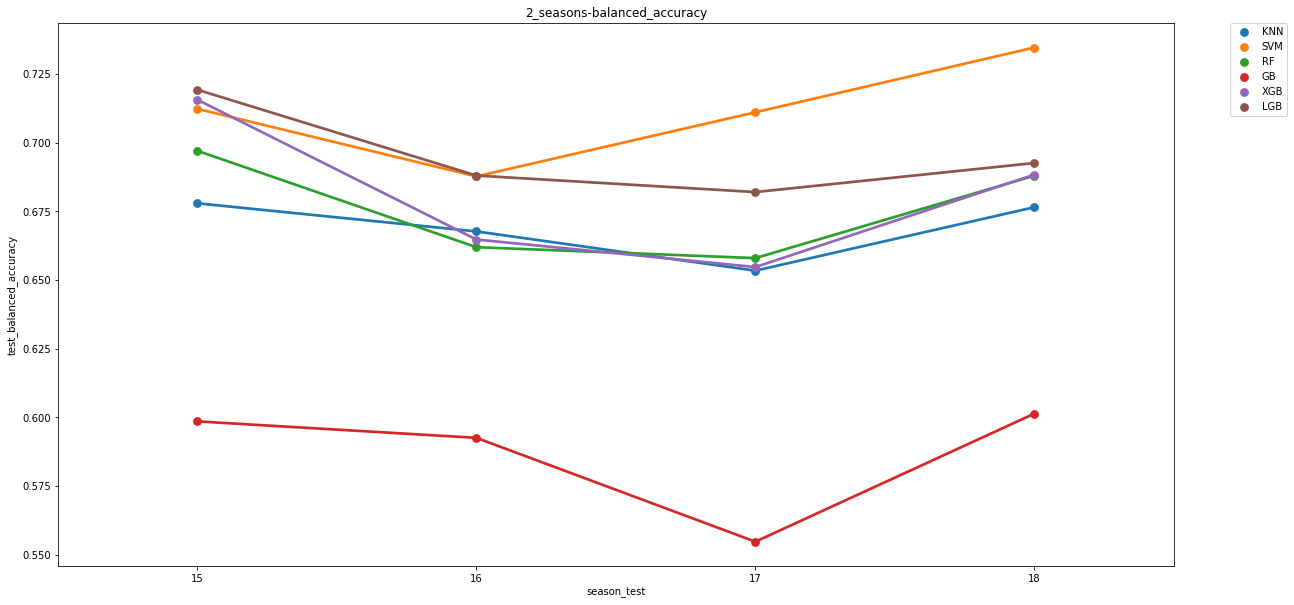

In [26]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de los resultados del experimento se observa lo siguiente:

    - Claramente SVM fue el algoritmo que mejor rendimiento tuvo en cada una de las validaciones.
    - Se evidencia un patron en el que todos los algoritmos tuvieron una caida de su rendimiento en la temporada 16 y continuo cayendo en el 17, a excepcion de RF que mejoro.
    - Otro patron que se evidencia es que para la temporada 2018 todos los algoritmos mejoraron.
    

### Experiment: train: 3s; test: 1s

In [27]:
experiment_name = f"{exp_prefix}3_seasons"

In [28]:
folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 3_seasons
Done


In [29]:
print_prettier_exp_results(experiment_name)

exp_name model  roc_auc_mean  roc_auc_std
19  3_seasons   SVM      0.710814     0.013518
23  3_seasons   LGB      0.685974     0.007731
22  3_seasons   XGB      0.678936     0.006787
20  3_seasons    RF      0.677389     0.005111
18  3_seasons   KNN      0.669474     0.004457
21  3_seasons    GB      0.578615     0.008029

- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***LGB***: Obtuvo el segundo promedio mas alto.
    - ***XGB***: Obtuvo el tercer promedio mas alto.
    
 Se destaca tambien que estos resultados son muy similares a los del experimento anterior(2s 1s)

In [30]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de cada validacion se observa lo siguiente:

    - Nuevamente SVM fue el algoritmo que mejor rendimiento tuvo en cada una de las validaciones.
    - Se evidencia un ligero patron de ascenso para los tres algoritmos con mejor rendimiento, lo cual indica cierta estabilidad en las validaciones de este experimento comparada con los experimentos anteriores.
    - Tambien se evidencia que comparado con los experimentos anteriores, en este el peor rendimiento estuvo en la primera validacion la del 16.

### Experiment train: 3q ; test: 1q

In [31]:
experiment_name = f"{exp_prefix}3q_1q"

In [32]:
folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 3q_1q
Done


In [33]:
print_prettier_exp_results(experiment_name)

exp_name model  roc_auc_mean  roc_auc_std
29    3q_1q   LGB      0.667840     0.039728
24    3q_1q   KNN      0.667185     0.039707
25    3q_1q   SVM      0.663372     0.078508
28    3q_1q   XGB      0.655548     0.037270
26    3q_1q    RF      0.647069     0.039492
27    3q_1q    GB      0.582281     0.053218

- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***LGB***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***KNN***: Obtuvo el segundo promedio mas alto.
    - ***SVM***: Obtuvo el tercer promedio mas alto.
    
 Comparado con el anterior experimento(3s 1s), estos resultados son peores, pero es importante destacar que se hicieron muchisimas mas validaciones que los experimentos anteriores. Ver grafico debajo.

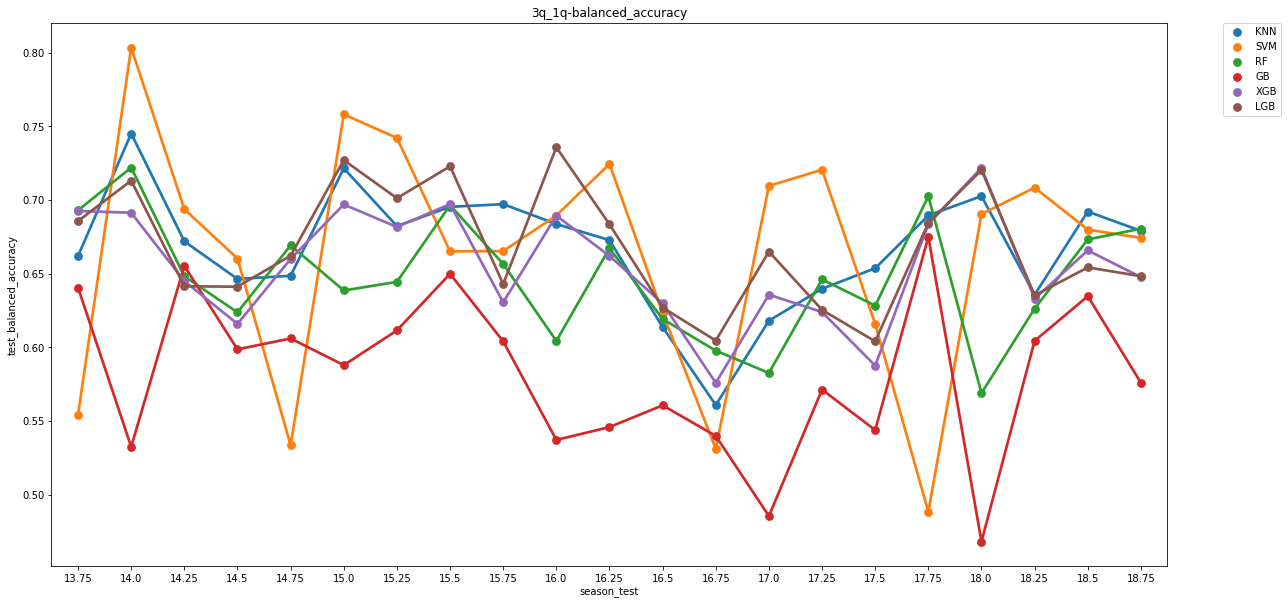

In [34]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de cada validacion se observa lo siguiente:

    - SVM fue bastante inestable, tuvo casi igual de picos de buenos rendimientos como caidas de malos rendientos.
    - Se observa un patron, en cada cuarto de temporada 0.25, que corresponde a la mitad(desde 0.25 a 0.5) pues el rendimiento de cada algoritmo tuvo una caida.

### Experiment train: 4q ; test: 2q

In [35]:
experiment_name = f"{exp_prefix}4q_2q"

In [36]:
folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 4q_2q
Done


In [37]:
print_prettier_exp_results(experiment_name)

exp_name model  roc_auc_mean  roc_auc_std
31    4q_2q   SVM      0.702563     0.042494
34    4q_2q   XGB      0.674543     0.032952
32    4q_2q    RF      0.674107     0.027322
35    4q_2q   LGB      0.669194     0.034668
30    4q_2q   KNN      0.665393     0.022240
33    4q_2q    GB      0.598441     0.027792

- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***XGB***: Obtuvo el segundo promedio mas alto.
    - ***RF***: Obtuvo el tercer promedio mas alto.


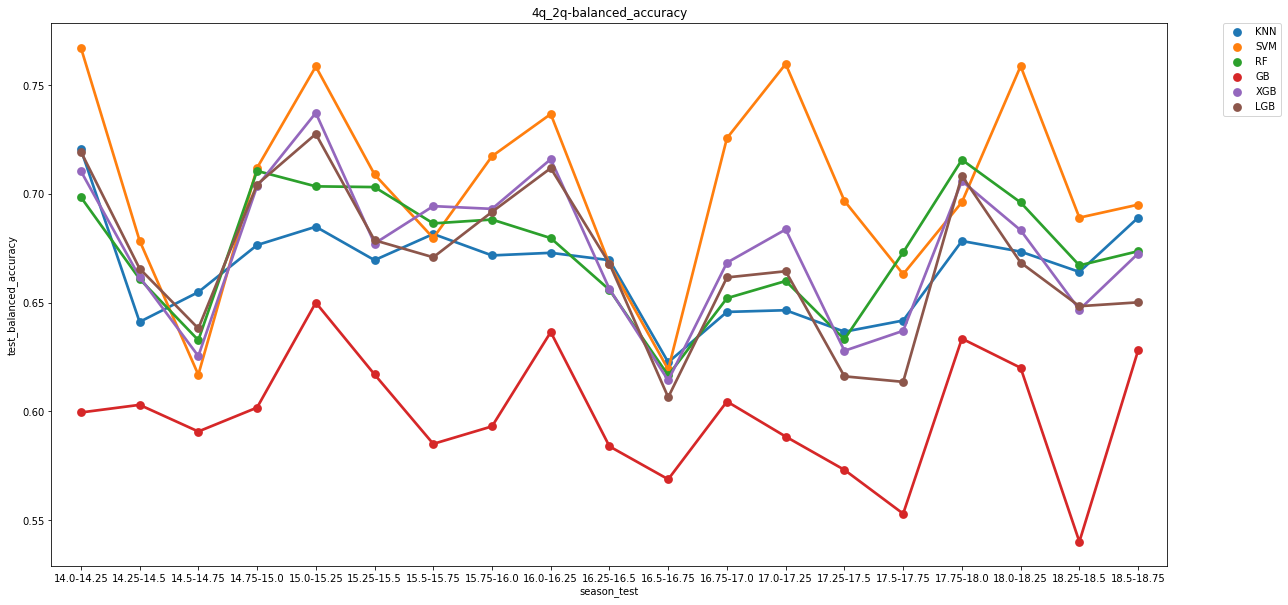

In [38]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de cada validacion se observa lo siguiente:

    - SVM fue un poco mas estable que el experimento anterior.
    - Se observa un patron, en cada validacion 0.5-0.75, es decir, que se trata de predecir la segunda mitad de la temporada, usando la primera mitad de la temporada actual y la ultima mitad de la anterior, pues hay una caida en el rendimiento de los algoritmos.

### Experiment remove first 1q ; train: 2q ; test: 1q

En este experimento se eliminara el primer cuarto de cada temporada, y se entrenara el modelo con los 2 siguientes cuartos, y como test 1 cuarto de temporada. La ventana deslisante sera de 1 cuarto.

In [39]:
experiment_name = f"{exp_prefix}r1q_2q_1q"

In [40]:
folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=1, skip=[0.25])
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment r1q_2q_1q
Done


In [41]:
print_prettier_exp_results(experiment_name)

exp_name model  roc_auc_mean  roc_auc_std
36  r1q_2q_1q   KNN      0.660306     0.039943
41  r1q_2q_1q   LGB      0.646228     0.038513
37  r1q_2q_1q   SVM      0.641917     0.075410
40  r1q_2q_1q   XGB      0.641808     0.039616
38  r1q_2q_1q    RF      0.640446     0.040713
39  r1q_2q_1q    GB      0.577732     0.052200

- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***KNN***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***LGB***: Obtuvo el segundo promedio mas alto.
    - ***SVM***: Obtuvo el tercer promedio mas alto.


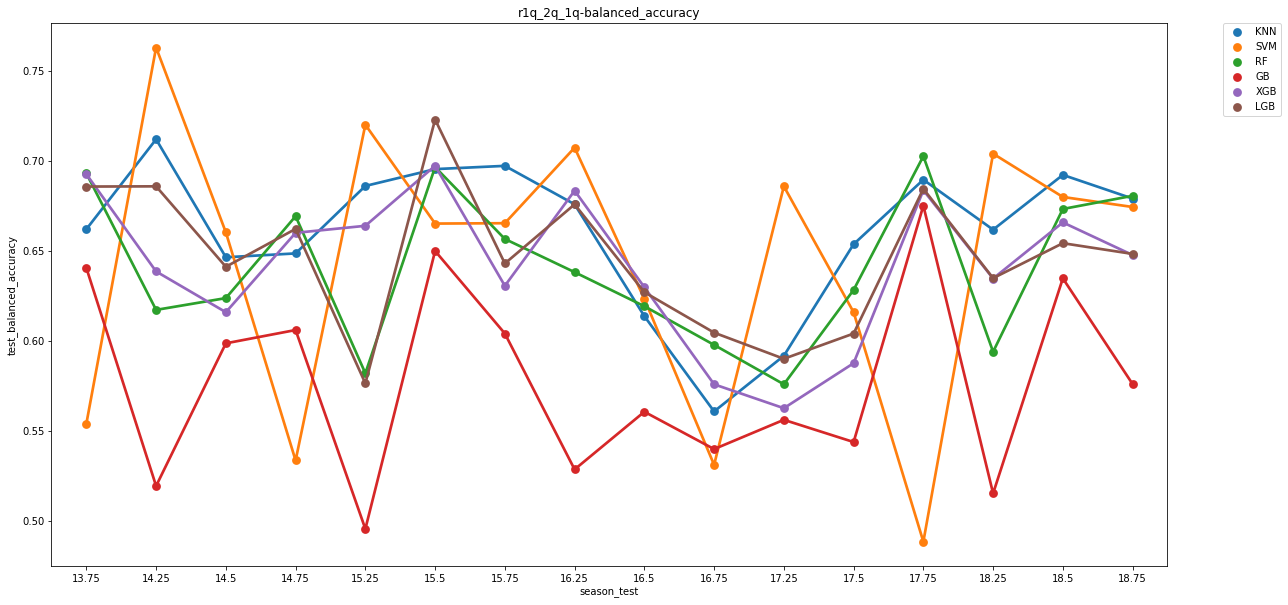

In [42]:
#### Visualize experiments results
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de cada validacion se observa lo siguiente:

    - Se observa un patron, en cada validacion .75, es decir, que se trata de predecir el ultimo cuarto de temporada, pues hay una caida del rendimiento en el caso del algoritmo SVM, sin embargo no es lo mismo para los otros algoritmos, al menos no para todos las validaciones .75.

## Experiments comparison

In [43]:
utils.serialize_object(exp_group_name, exp.exp_results)

In [44]:
exp_df = get_results_df()

In [45]:
ba_df = exp_df[['exp_name', 'model',
       'balanced_accuracy_mean', 'balanced_accuracy_std']]

In [46]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(ba_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [47]:
ba_df.sort_values(
    by=["balanced_accuracy_mean"]
    , ascending=False)[:6].reset_index().drop(labels=["index"], axis=1)

exp_name model  balanced_accuracy_mean  balanced_accuracy_std
0  2_seasons   SVM                0.711381               0.016598
1  3_seasons   SVM                0.710814               0.013518
2      4q_2q   SVM                0.702563               0.042494
3   1_season   SVM                0.700944               0.023601
4  2_seasons   LGB                0.695420               0.014239
5  3_seasons   LGB                0.685974               0.007731

Basado en la metrica 'balanced_accuracy_mean' se observa:

- El algoritmo SVM obtuvo el mejor rendimiento para la mayoria de los experimentos. LGB fue el algoritmo siguiente que obtuvo el mejor rendimiento. 
- En los experimentos que se obtuvo el mejor rendimiento fueron usando 2 y 3 temporadas para entrenamiento para predecir al siguiente.
    

## Plot experiment results

In [64]:
utils.serialize_object("results", exp.exp_results)
utils.serialize_object("results_total", results_total)

### Balance Accuracy

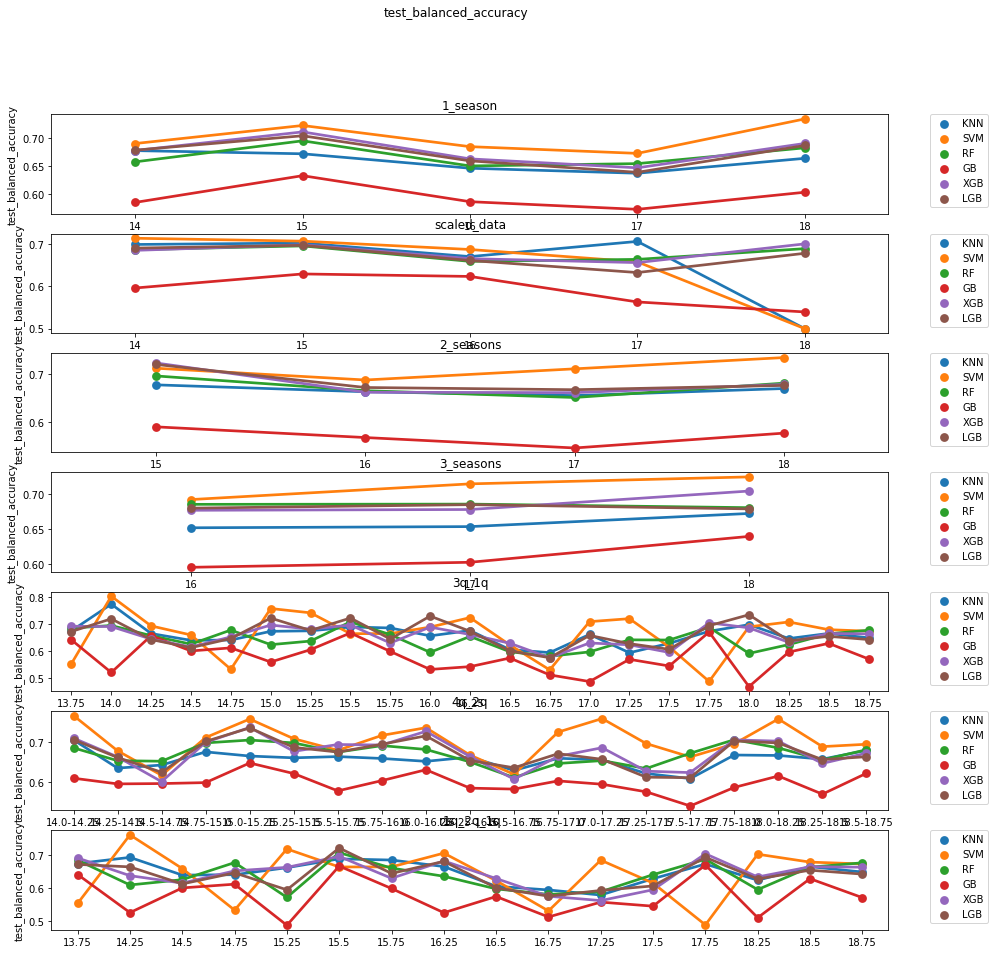

In [65]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_balanced_accuracy", 
    figsize=(15, 15),
    use_pointplot=True
)

### Precision

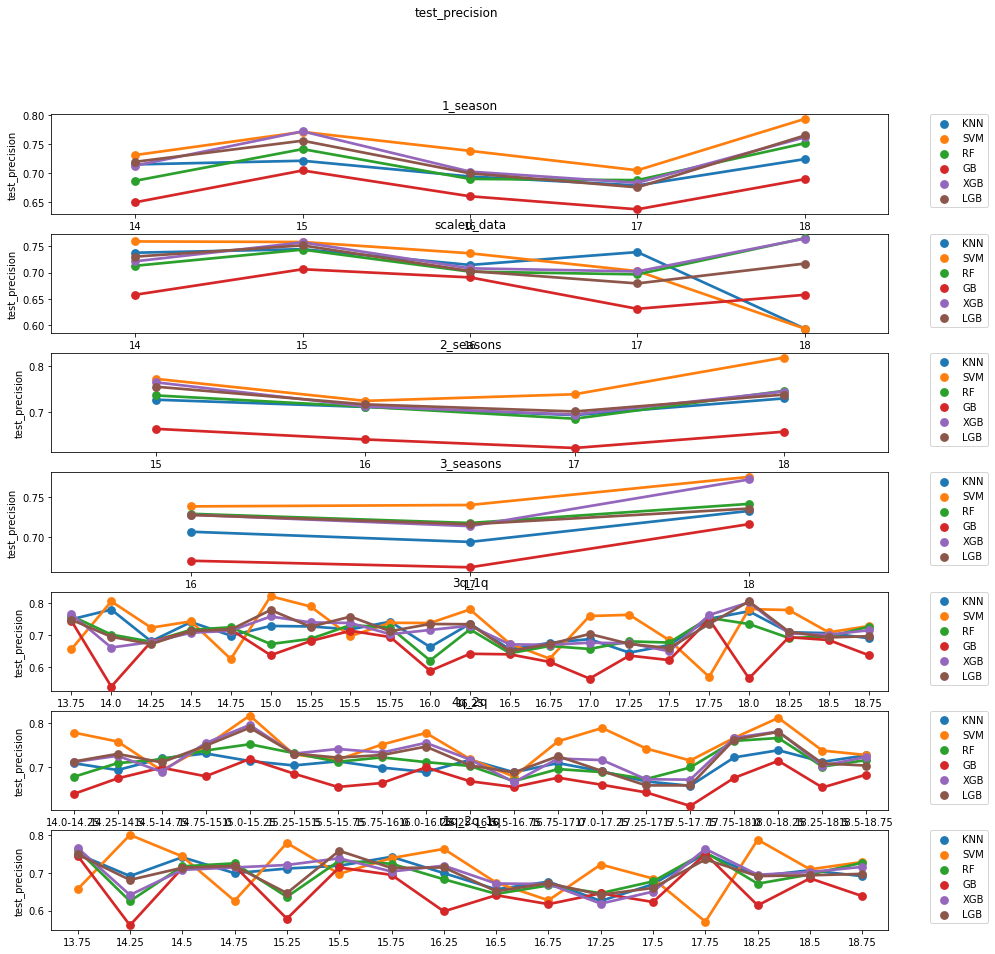

In [66]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_precision", 
    figsize=(15, 15),
    use_pointplot=True
)

### Recall

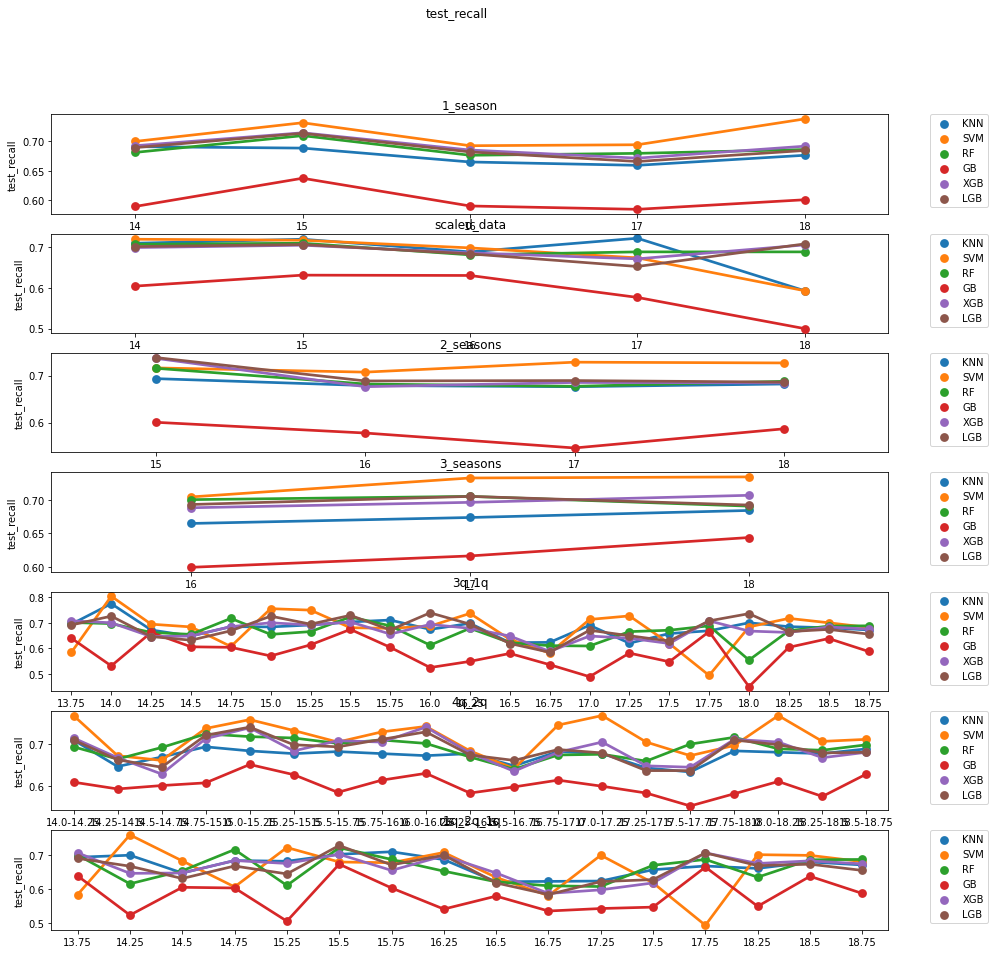

In [67]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_recall", 
    figsize=(15, 15),
    use_pointplot=True
)

### F1

In [68]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_f1", 
    figsize=(15, 15),
    use_pointplot=True
)

### ROC AUC

In [69]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_roc_auc", 
    figsize=(15, 25),
    use_pointplot=True
)

## Tuning model

A partir de los experimentos y basado en las observaciones realizadas trabajaremos de ahora en adelante solo con los modelos: SVM y LGB.

Para el entrenamiento cada modelo utilizaremos las variantes:

- Train: 2 seasons ; Test: 1 season ; Ventana deslizante de: 1 season
- Train: 3 seasons ; Test: 1 season ; Ventana deslizante de: 1 season

### Setup

In [15]:
results_total = []
exp.exp_results = []
experiment_name = f"{exp_prefix}2_season_tunning"
best_models = [
    ("RF", RandomForestClassifier(n_estimators=300,
                                                max_depth=11,
                                                n_jobs=-1,
                                                random_state=0,
                                                criterion='entropy',
                                                max_features=19,
                                                min_samples_leaf=9,
                                 )),
    ('SVM', SVC(kernel='linear', random_state=0,
                              C=63.513891775842986,
                              gamma=76.1465194934807,
                              degree= 0.4300244876201068))
]
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
#params = (experiment_name, best_models, folds, train_seasons, test_seasons, X, y)
#names, results = exp.run_experiment(*params)
#results_total.append((experiment_name, results))

NameError: name 'RandomForestClassifier' is not defined

In [106]:
from yellowbrick.style import set_palette
import warnings
import io
from sklearn import base, metrics, model_selection, preprocessing, tree
from yellowbrick.classifier import ROCAUC
import yellowbrick.classifier

set_palette('flatui')
fold_last_season = folds[len(folds)-1:]
name, model = best_models[0]

### Explore models perfomance

Test season: 15


/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ConfusionMatrix(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7febb9f1b290>,
                cmap=<matplotlib.colors.ListedColormap object at 0x7febbb30c290>,
                model=None, percent=True)

0.6983739837398374

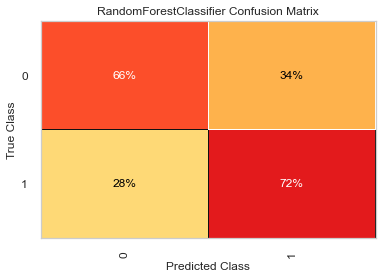

<Figure size 6000x6000 with 0 Axes>

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureImportances(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7febb8052e10>,
                   labels=['SEASON', 'HT_RANK', 'VT_RANK', 'HT_HW', 'HT_VW',
                           'HT_LAST10_W', 'HT_LAST10_MATCHUP_W',
                           'HT_OVERALL_OFF_POINTS', 'HT_OVERALL_DEF_POINTS',
                           'HT_OVERALL_OFF_FG', 'HT_OVERALL_DEF_FG',
                           'HT_OVERALL_OFF_3P', 'HT_OVERALL_DEF_3P',
                           'HT_OVERALL_OFF_FT', 'HT_OVERALL_DEF_FT',
                           'HT_OVERALL_OFF_REB', 'HT_OVERALL_DEF_REB',
                           'HT_AWAY_POINTS', 'HT_AWAY_FG', 'HT_AWAY_3P',
                           'HT_AWAY_FT', 'HT_AWAY_REB', 'VT_HW', 'VT_VW',
                           'VT_LAST10_W', 'VT_LAST10_MATCHUP_W',
                           'VT_OVERALL_OFF_POINTS', 'VT_OVERALL_DEF_POINTS',
                           'VT_OVERALL_OFF_FG', 'VT_OVERALL_DEF_FG', ...],
                   model=None, relative=False)

0.6983739837398374

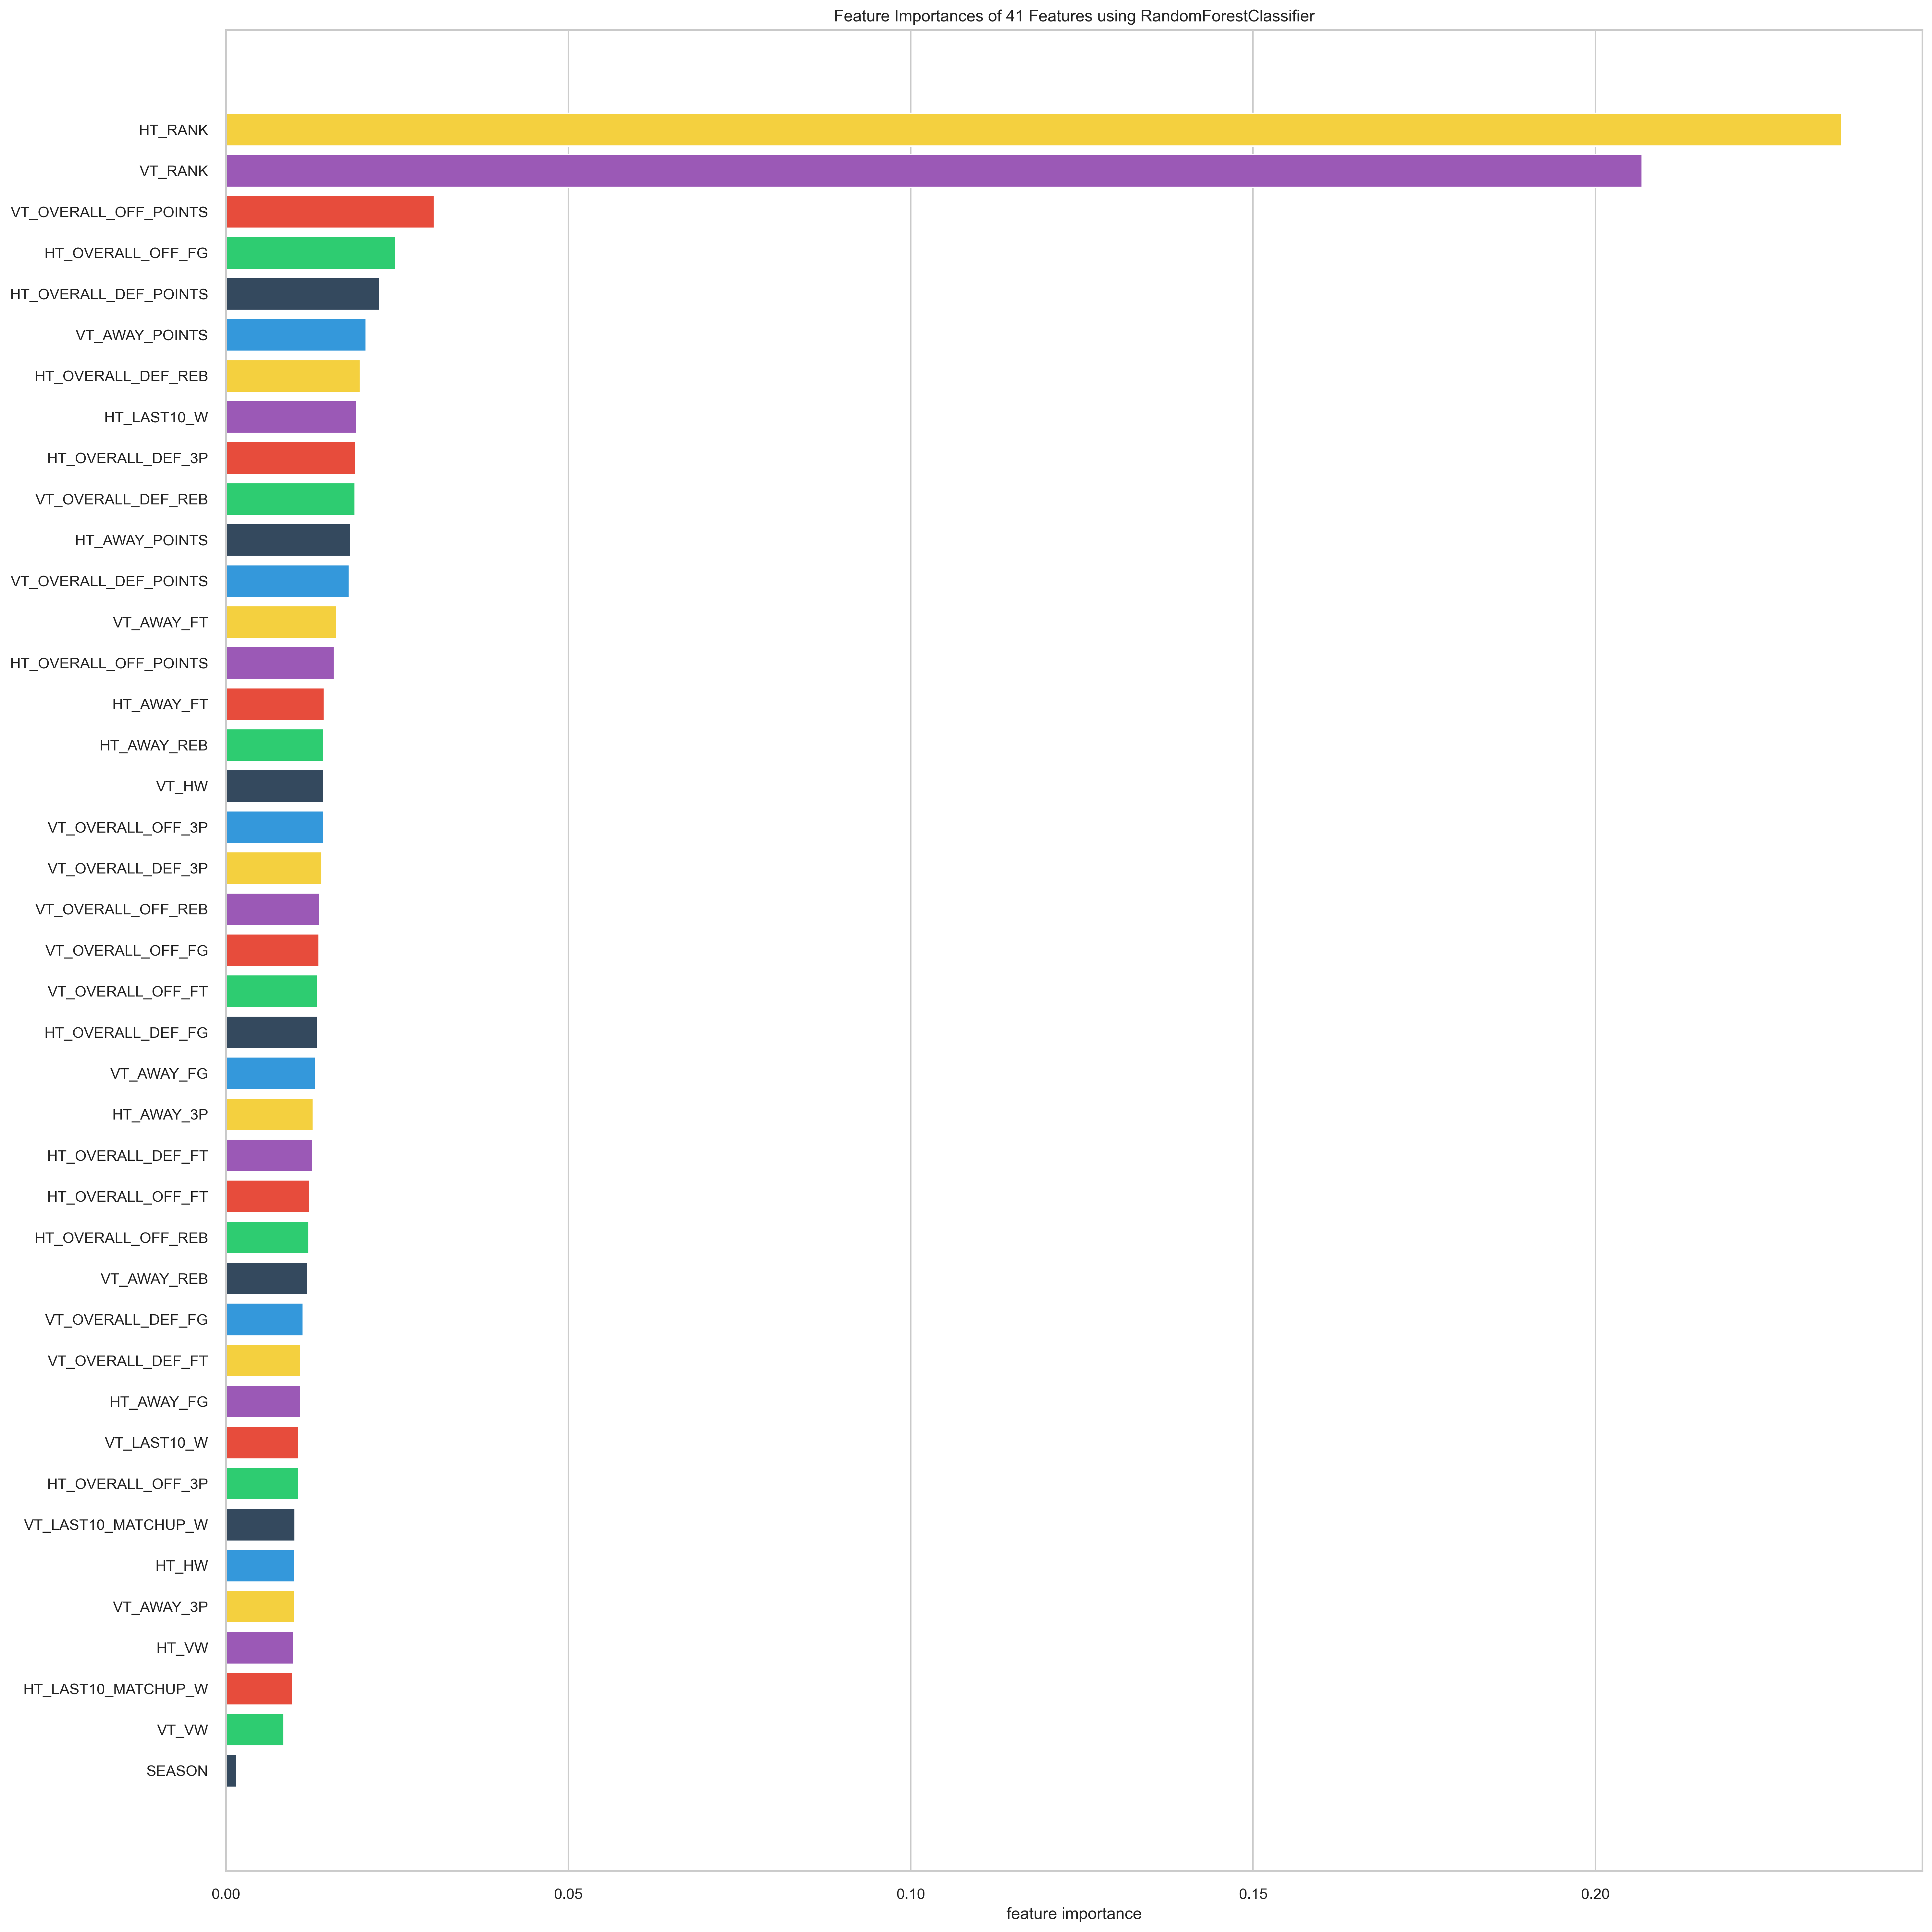

Test season: 15


/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ConfusionMatrix(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7febb93e74d0>,
                cmap=<matplotlib.colors.ListedColormap object at 0x7febb8e852d0>,
                model=None, percent=True)

0.71869918699187

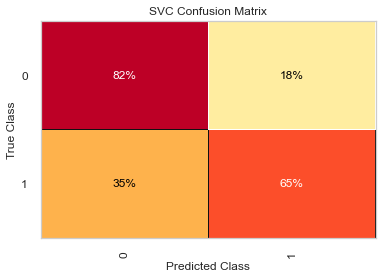

<Figure size 6000x6000 with 0 Axes>

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:195: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,
/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureImportances(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7febb8f5bc10>,
                   labels=['SEASON', 'HT_RANK', 'VT_RANK', 'HT_HW', 'HT_VW',
                           'HT_LAST10_W', 'HT_LAST10_MATCHUP_W',
                           'HT_OVERALL_OFF_POINTS', 'HT_OVERALL_DEF_POINTS',
                           'HT_OVERALL_OFF_FG', 'HT_OVERALL_DEF_FG',
                           'HT_OVERALL_OFF_3P', 'HT_OVERALL_DEF_3P',
                           'HT_OVERALL_OFF_FT', 'HT_OVERALL_DEF_FT',
                           'HT_OVERALL_OFF_REB', 'HT_OVERALL_DEF_REB',
                           'HT_AWAY_POINTS', 'HT_AWAY_FG', 'HT_AWAY_3P',
                           'HT_AWAY_FT', 'HT_AWAY_REB', 'VT_HW', 'VT_VW',
                           'VT_LAST10_W', 'VT_LAST10_MATCHUP_W',
                           'VT_OVERALL_OFF_POINTS', 'VT_OVERALL_DEF_POINTS',
                           'VT_OVERALL_OFF_FG', 'VT_OVERALL_DEF_FG', ...],
                   model=None, relative=False)

0.71869918699187

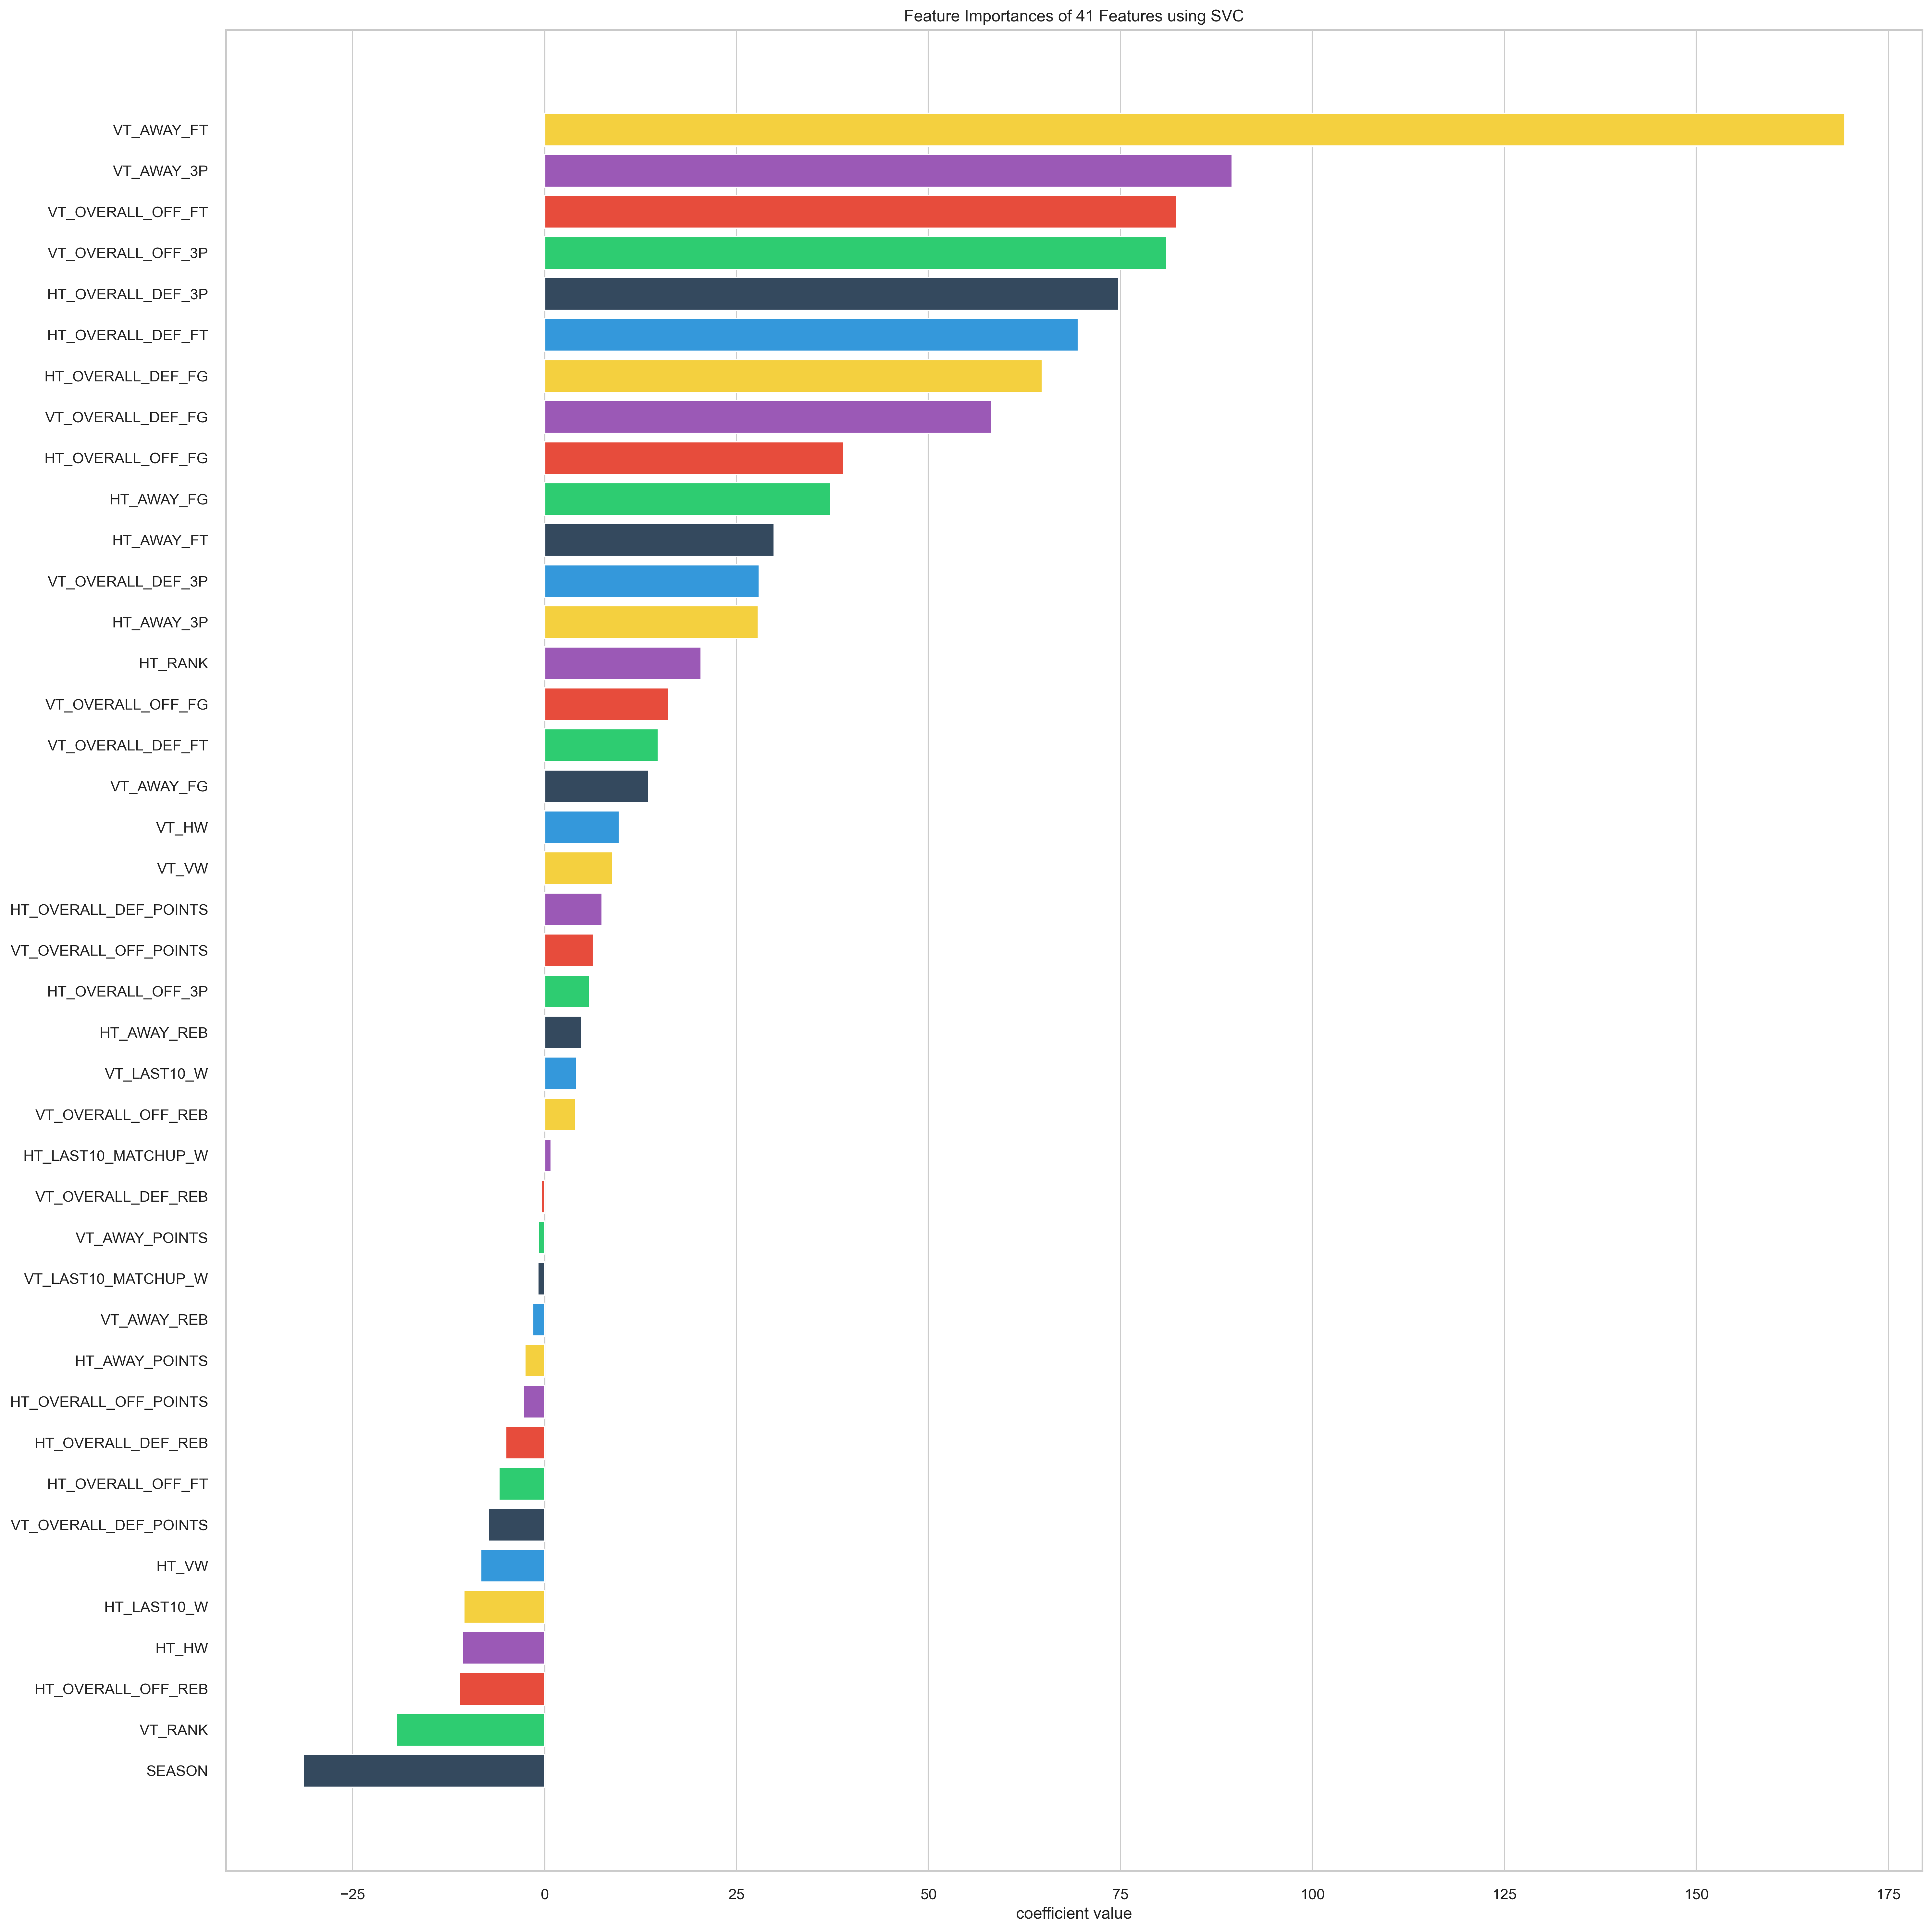

In [57]:


#warnings.filterwarnings('ignore')
fold_last_season = folds[len(folds)-1:]
for name, model in best_models:
    for i, idx_data in enumerate(fold_last_season):
        print(f"Test season: {test_seasons[i]}")
        train_idx, test_idx = idx_data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx].ravel(), y[test_idx].ravel()
        y_true = y_test
        fit_info = model.fit(X_train, y_train)
        
        #with sns.plotting_context('paper'):
        #    fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
        cm_viz = classifier.ConfusionMatrix(model, percent=True)
        cm_viz.fit(X_train, y_train)
        cm_viz.score(X_test, y_test)
        cm_viz.show()
        #cm_viz.poof()
        #with sns.plotting_context('talk'):
            #fig, ax = plt.subplots(figsize=(20, 20), dpi=300)
        plt.figure(figsize=(20, 20), dpi=300)
        fi_viz = features.FeatureImportances(model, labels=exp_X_columns, relative=False)
        fi_viz.fit(X_train, y_train)
        fi_viz.score(X_test, y_test)
        #fi_viz.poof()
        fi_viz.show()

### ROC AUC

Test season: 15


0.6993420566274858

roc_auc: <function roc_auc_score at 0x7febd4daeb90>


/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


0.7598773999498567

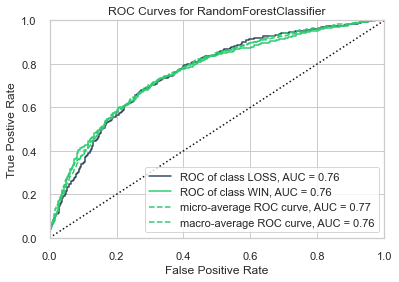

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


0.7024390243902439

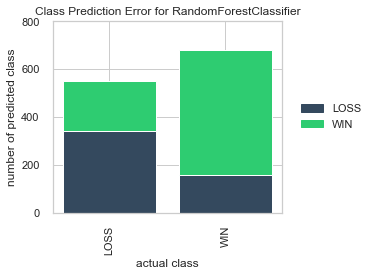

In [107]:
for i, idx_data in enumerate(fold_last_season):
    print(f"Test season: {test_seasons[i]}")
    train_idx, test_idx = idx_data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx].ravel(), y[test_idx].ravel()
    y_true = y_test
    fit_info = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_auc_score(y_true, y_pred, average='weighted')
    print(f'roc_auc: {roc_auc_score}')
    roc_viz = ROCAUC(model, classes=['LOSS', 'WIN'])
    roc_viz.score(X_test, y_test)
    roc_viz.show()
    
    roc_viz = classifier.ClassPredictionError(model, classes=['LOSS', 'WIN'])
    roc_viz.score(X_test, y_test)
    roc_viz.show()

### Hyperopt

In [ ]:
v_folds = folds[:-1]
test_fold = folds[-1]
#name, model = best_models[0]

In [ ]:
from sklearn.metrics import roc_auc_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

#### SVM

In [18]:
def hyperopt_cv(params):
    cv_results = {
            "roc_auc": []
        }
    
    #del params['normalize']
    #del params['scale']

    for train_idx, test_idx in v_folds:
        X[train_idx], X[test_idx] = utils.feature_scaling(X[train_idx], X[test_idx], 5)
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx].ravel(), y[test_idx].ravel()
        y_true = y_test
        model = SVC(**params)
        fit_info = model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        roc_auc = roc_auc_score(y_true, y_pred, average='weighted')
        cv_results["roc_auc"].append(roc_auc)

    return np.mean(cv_results["roc_auc"])

space4svm = {
    'C': hp.uniform('C', 0, 100),
    'kernel': hp.choice('kernel', ['linear']),
    'gamma': hp.uniform('gamma', 0, 100),
    'degree': hp.uniform('degree', 0, 6)
    #'scale': hp.choice('scale', [0, 1]),
    #'normalize': hp.choice('normalize', [0, 1])
}

# best: {'C': 63.513891775842986, 'degree': 0.4300244876201068, 'gamma': 76.1465194934807, 'kernel': 0}
def f(params):
    acc = hyperopt_cv(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4svm, algo=tpe.suggest, max_evals=100, trials=trials)
print("best:", best)

100%|██████████| 100/100 [03:26<00:00,  2.07s/trial, best loss: -0.7071538430757435]
best: {'C': 63.513891775842986, 'degree': 0.4300244876201068, 'gamma': 76.1465194934807, 'kernel': 0}


#### RandomForest

In [102]:
def hyperopt_train_test(params):
    cv_results = {
            "roc_auc": []
        }
    
    #del params['normalize']
    #del params['scale']

    for train_idx, test_idx in v_folds:
        X[train_idx], X[test_idx] = utils.feature_scaling(X[train_idx], X[test_idx], 5)
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx].ravel(), y[test_idx].ravel()
        y_true = y_test
        model = RandomForestClassifier(**params)
        fit_info = model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        roc_auc = roc_auc_score(y_true, y_pred, average='weighted')
        cv_results["roc_auc"].append(roc_auc)

    return np.mean(cv_results["roc_auc"])

space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,20)),
    'n_estimators': hp.choice('n_estimators', range(100, 500, 50)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'min_samples_leaf':  hp.choice('min_samples_leaf',  np.arange(1, 20, step=1, dtype=int)),
    #'min_samples_split': None,
    #'max_leaf_nodes': None
    #'scale': hp.choice('scale', [0, 1]),
    #'normalize': hp.choice('normalize', [0, 1])
}
best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
    print('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=300, trials=trials)
print("best:", best)

new best:                                              
0.6597088317776479                                     
{'criterion': 'gini', 'max_depth': 15, 'max_features': 5, 'min_samples_leaf': 12, 'n_estimators': 350}
new best:                                                                         
0.6770312782428856                                                                
{'criterion': 'entropy', 'max_depth': 6, 'max_features': 16, 'min_samples_leaf': 12, 'n_estimators': 450}
new best:                                                                         
0.6770312782428856                                                                
{'criterion': 'gini', 'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 5, 'n_estimators': 300}
new best:                                                                         
0.6770312782428856                                                                
{'criterion': 'gini', 'max_depth': 18, 'max_features': 6, 'min_samples_leaf': 8

new best:                                                                          
0.6946939027984641                                                                 
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 9, 'min_samples_leaf': 2, 'n_estimators': 350}
new best:                                                                          
0.6946939027984641                                                                 
{'criterion': 'entropy', 'max_depth': 18, 'max_features': 11, 'min_samples_leaf': 9, 'n_estimators': 200}
new best:                                                                          
0.6946939027984641                                                                 
{'criterion': 'gini', 'max_depth': 17, 'max_features': 19, 'min_samples_leaf': 3, 'n_estimators': 150}
new best:                                                                          
0.6946939027984641                                                                 
{'criterion': 

new best:                                                                          
0.6946939027984641                                                                 
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 7, 'min_samples_leaf': 14, 'n_estimators': 300}
new best:                                                                          
0.6946939027984641                                                                 
{'criterion': 'entropy', 'max_depth': 1, 'max_features': 15, 'min_samples_leaf': 9, 'n_estimators': 450}
new best:                                                                          
0.6946939027984641                                                                 
{'criterion': 'gini', 'max_depth': 16, 'max_features': 3, 'min_samples_leaf': 4, 'n_estimators': 350}
new best:                                                                          
0.6946939027984641                                                                 
{'criterion': 'e

0.6946939027984641                                                                  
{'criterion': 'entropy', 'max_depth': 15, 'max_features': 14, 'min_samples_leaf': 13, 'n_estimators': 100}
new best:                                                                           
0.6946939027984641                                                                  
{'criterion': 'entropy', 'max_depth': 11, 'max_features': 17, 'min_samples_leaf': 13, 'n_estimators': 100}
new best:                                                                           
0.6946939027984641                                                                  
{'criterion': 'entropy', 'max_depth': 17, 'max_features': 19, 'min_samples_leaf': 13, 'n_estimators': 100}
new best:                                                                           
0.6946939027984641                                                                  
{'criterion': 'entropy', 'max_depth': 9, 'max_features': 2, 'min_samples_leaf': 9, '

{'criterion': 'entropy', 'max_depth': 2, 'max_features': 15, 'min_samples_leaf': 1, 'n_estimators': 400}
new best:                                                                           
0.6946939027984641                                                                  
{'criterion': 'entropy', 'max_depth': 15, 'max_features': 6, 'min_samples_leaf': 13, 'n_estimators': 300}
new best:                                                                           
0.6946939027984641                                                                  
{'criterion': 'entropy', 'max_depth': 12, 'max_features': 7, 'min_samples_leaf': 9, 'n_estimators': 250}
new best:                                                                           
0.6946939027984641                                                                  
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 17, 'n_estimators': 350}
new best:                                                            

new best:                                                                           
0.6948484169432766                                                                  
{'criterion': 'entropy', 'max_depth': 12, 'max_features': 8, 'min_samples_leaf': 9, 'n_estimators': 200}
new best:                                                                           
0.6948484169432766                                                                  
{'criterion': 'entropy', 'max_depth': 17, 'max_features': 1, 'min_samples_leaf': 6, 'n_estimators': 200}
new best:                                                                           
0.6948484169432766                                                                  
{'criterion': 'entropy', 'max_depth': 11, 'max_features': 19, 'min_samples_leaf': 11, 'n_estimators': 300}
new best:                                                                           
0.6948484169432766                                                                  
{'c

In [124]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgboost

def hyperopt_train_test(params):
    t = params['type']
    del params['type']
    if t == 'RF':
        clf = RandomForestClassifier(**params)
    elif t == 'SVM':
        clf = SVC(**params)
    elif t == 'XGB':
        clf = xgb.XGBClassifier(**params)
    elif t == 'LGB':
        clf = lgb.LGBMClassifier(**params)
    else:
        return 0

    cv_results = {
            "roc_auc": []
        }
    
    #del params['normalize']
    #del params['scale']

    for train_idx, test_idx in v_folds:
        X[train_idx], X[test_idx] = utils.feature_scaling(X[train_idx], X[test_idx], 5)
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx].ravel(), y[test_idx].ravel()
        y_true = y_test
        fit_info = clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        roc_auc = roc_auc_score(y_true, y_pred, average='weighted')
        cv_results["roc_auc"].append(roc_auc)

    return np.mean(cv_results["roc_auc"])

space = hp.choice('classifier_type', [
    {
        'type': 'LGB',
        'n_estimators': hp.choice('n_estimators2', range(100, 500, 50)),
        'max_depth': hp.choice('max_depth2', range(1,20)),
        'num_leaves': hp.choice('num_leaves2', np.arange( 30, 150, 1, dtype=int)),
        'reg_alpha': hp.quniform('reg_alpha2', 0.0, 1.0, 0.1),
        'reg_lambda': hp.quniform('reg_lambda2', 0.0, 1.0, 0.1),
        'learning_rate': hp.loguniform('learning_rate2', np.log(0.01), np.log(0.2)),
        'min_child_weight': hp.choice('min_child_weight2', [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]),
        'min_child_samples': hp.choice('min_child_samples2', np.arange( 20, 500, 5, dtype=int))
    },
    {
        'type': 'SVM',
        'C': hp.uniform('C', 0, 100),
        'kernel': hp.choice('kernel', ['linear']),
        'gamma': hp.uniform('gamma', 0, 100),
        'degree': hp.uniform('degree', 0, 6)
    },{
        'type': 'XGB',
        'n_estimators': hp.choice('n_estimators1', range(100, 500, 50)),
        'max_depth': hp.choice('max_depth1', range(1,20)),
        #'num_leaves': hp.choice('num_leaves1', np.arange( 30, 150, 1, dtype=int)),
        'reg_alpha': hp.quniform('reg_alpha1', 0.0, 1.0, 0.1),
        'reg_lambda': hp.quniform('reg_lambda1', 0.0, 1.0, 0.1),
        'learning_rate': hp.loguniform('learning_rate1', np.log(0.01), np.log(0.2)),
        'min_child_weight': hp.choice('min_child_weight1', [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]),
        #'min_child_samples': hp.choice('min_child_samples1', np.arange( 20, 500, 5, dtype=int)),
    },
#     {
#         'type': 'RF',
#         'max_depth': hp.choice('max_depth', range(1,20)),
#         'max_features': hp.choice('max_features', range(1,20)),
#         'n_estimators': hp.choice('n_estimators', range(100, 500, 50)),
#         'criterion': hp.choice('criterion', ["gini", "entropy"]),
#         'min_samples_leaf':  hp.choice('min_samples_leaf',  np.arange(1, 20, step=1, dtype=int))
#         #'scale': hp.choice('scale', [0, 1]),
#         #'normalize': hp.choice('normalize', [0, 1])
#     }
])
count = 0
best = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params.copy())
    if acc > best:
        print('new best:', acc, 'using', params['type'])
        best = acc
    if count % 50 == 0:
        print('iters:', count, ', acc:', acc, 'using', params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=1000, trials=trials)
print('best:', best)

new best:                                               
0.6991020330751582                                      
using                                                   
XGB                                                     
new best:                                                                          
0.7046321746604721                                                                 
using                                                                              
SVM                                                                                
new best:                                                                           
0.7074062610677236                                                                  
using                                                                               
SVM                                                                                 
iters:                                                                              
50         